<a href="https://colab.research.google.com/github/siro844/SAM-WebApp/blob/main/SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
## requiremnts
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install torch torchvision opencv-python numpy

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-1zvk7tgn
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-1zvk7tgn
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [2]:
## create sam predictor
import os
from segment_anything import SamPredictor,sam_model_registry
model_path='./sam_vit_b_01ec64.pth'
if not os.path.exists(model_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
sam = sam_model_registry["vit_b"](checkpoint=model_path)
predictor = SamPredictor(sam)


--2024-03-09 14:28:59--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.108, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   122MB/s    in 2.9s    

2024-03-09 14:29:02 (122 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [9]:
## load image and select x and y coordinates to test
import cv2

image_path = './test.jpg'
if not os.path.exists(image_path):
  !wget https://utils-computervisiondeveloper.s3.amazonaws.com/media/public/test.jpg

x=528
y=606
image=cv2.imread(image_path)
_,image_bytes=cv2.imencode('.png',image)

image_bytes=image_bytes.tobytes()

image_bytes_encoded_base64=base64.b64encode(image_bytes).decode('utf-8')



In [ ]:
# use sam predictor on the image,x,y to get location of subject
import numpy as np
predictor.set_image(image)

masks,scores,logits=predictor.predict(
    point_coords=np.asarray([[x,y]]),
    point_labels=np.asarray([1]),
    multimask_output=True
)

C,H,W=masks.shape

result_mask=np.zeros((H,W),dtype=bool)

for j in range(C):
  result_mask |=masks[j,:,:]

result_mask=result_mask.astype(np.uint8)

In [ ]:
#remove background
alpha_channel=np.ones(result_mask.shape,dtype=result_mask.dtype)*255

alpha_channel[result_mask==0]=0

result_image=cv2.merge((image,alpha_channel))

In [8]:
#wrap it up as function
import base64
import numpy as np
import os
import cv2

from segment_anything import SamPredictor,sam_model_registry
model_path='./sam_vit_b_01ec64.pth'
if not os.path.exists(model_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
sam = sam_model_registry["vit_b"](checkpoint=model_path)
predictor = SamPredictor(sam)
def remove_background(image_base64_encoded,x,y):

  image_bytes=base64.b64decode(image_base64_encoded)

  image=cv2.imdecode(np.frombuffer(image_bytes,dtype=np.uint8),cv2.IMREAD_COLOR)

  predictor.set_image(image)
  masks,scores,logits=predictor.predict(
      point_coords=np.asarray([[x,y]]),
      point_labels=np.asarray([1]),
      multimask_output=True
  )

  C,H,W=masks.shape

  result_mask=np.zeros((H,W),dtype=bool)

  for j in range(C):
    result_mask |=masks[j,:,:]

  result_mask=result_mask.astype(np.uint8)
  alpha_channel=np.ones(result_mask.shape,dtype=result_mask.dtype)*255

  alpha_channel[result_mask==0]=0

  result_image=cv2.merge((image,alpha_channel))

  _,result_image_bytes=cv2.imencode('.png',result_image)

  result_image_bytes=result_image_bytes.tobytes()

  result_image_bytes_encoded_base64=base64.b64encode(result_image_bytes).decode('utf-8')

  return result_image_bytes_encoded_base64

In [15]:
result=remove_background(image_bytes_encoded_base64,x,y)

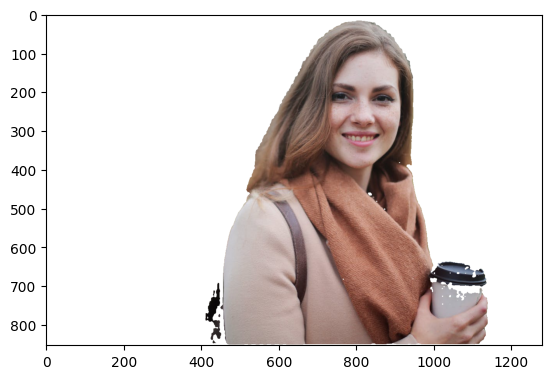

In [17]:
import matplotlib.pyplot as plt
result_bytes=base64.b64decode(result)
result_image=cv2.imdecode(np.frombuffer(result_bytes,dtype=np.uint8),cv2.IMREAD_UNCHANGED)
plt.imshow(cv2.cvtColor(result_image,cv2.COLOR_BGRA2RGBA))

In [18]:
!pip install modelbit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.8/124.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of types-requests to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of types-requests to determine which version is compatible with other requirements. This could take a while.
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully u

In [6]:
import modelbit

mb=modelbit.login()

In [9]:
mb.deploy(remove_background)

Uploading 'predictor': 100%|██████████| 348M/348M [00:10<00:00, 32.3MB/s]


In [11]:
import requests

In [12]:
import cv2

api='https://srinathreddy.ap-south-1.modelbit.com/v1/remove_background/latest'
image_path = './test.jpg'

if not os.path.exists(image_path):
  !wget https://utils-computervisiondeveloper.s3.amazonaws.com/media/public/test.jpg

x=528
y=606
image=cv2.imread(image_path)
_,image_bytes=cv2.imencode('.png',image)

image_bytes=image_bytes.tobytes()

image_bytes_encoded_base64=base64.b64encode(image_bytes).decode('utf-8')
api_data={'data':[image_bytes_encoded_base64,x,y]}
response=requests.post(api,json=api_data)
result=response.json()['data']
result_bytes=base64.b64decode(result)
result_image=cv2.imdecode(np.frombuffer(result_bytes,dtype=np.uint8),cv2.IMREAD_UNCHANGED)


NameError: name 'plt' is not defined

In [10]:
!pip install requests



In [13]:
import matplotlib.pyplot as plt

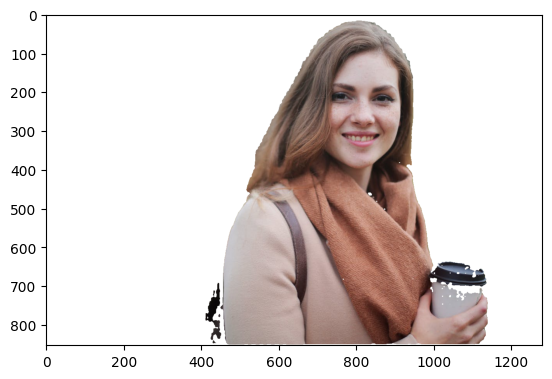

In [14]:
plt.imshow(cv2.cvtColor(result_image,cv2.COLOR_BGRA2RGBA))